Results for:

In [1]:
AGENT_NAME = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_24_bins_500'
DATASET_NAME = 'citylearn_challenge_2022_phase_2' #only action is electrical storage

In [2]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from art.attacks.evasion import AutoConjugateGradient as ACG

import pandas as pd
import numpy as np

import KBMproject.utilities as utils

%matplotlib inline

In [3]:
schema = DataSet.get_schema(DATASET_NAME)

Define RL agent

In [4]:
agent = PPO.load(path=f"Models/Victim/{AGENT_NAME}")
print('Model loaded from storage')

Model loaded from storage


In [5]:
bins = agent.action_space[0].n
env = utils.make_discrete_env(schema=schema,  
                        action_bins=bins,
                        seed=42)

Unperturbed agent performance

In [6]:
baseline_kpis, baseline_obs, baseline_a = utils.eval_agent(env,agent)
display(baseline_kpis)

cost_function
annual_peak_average                      1.000000
carbon_emissions_total                   0.870297
cost_total                               0.793112
daily_one_minus_load_factor_average      1.102841
daily_peak_average                       0.898169
electricity_consumption_total            0.881560
monthly_one_minus_load_factor_average    0.982159
ramping_average                          1.107352
zero_net_energy                          1.100263
Name: District, dtype: float64

We will use feature permutations to determine attribute the importance of each feature. 
- The Battery's charge and time of day are by far the most important features for this model.
- Time features have higher importance the the power consumed by the non-shiftable load, suggesting the model has learned a schedule.
- It's strange that solar irradience features are just below most time features, but solar generation has the second lowest importance. I suspect that these feature are correlated with the hour and season (month), and are considered similar by the model.
- the same may be true of electricity pricing (cost is not part of the reward)
- Because the agent doesn't control the interior climate the related power consumption is capture by the non-shiftable load, it's understand able that the outdoor temperatures and humidities are not important.
- Considering that the reward function is -net-electricity consummption, it's odd that it is the least important feature. I suspect it's value and solar generation are very small portions of the non shiftable load, are are not significant when considered next to it. I suspect this would be different for an agent controlling a larger proportion solar and storage capacities

In [7]:
observation_names = env.observation_names[0]

In [8]:
attributions = utils.get_feature_permutations(agent, baseline_obs, baseline_a)
attributions = pd.Series(attributions, index=observation_names)
display(attributions.sort_values(ascending=False))

hour_cos                                      2.202549
electrical_storage_soc                        1.791301
day_type_cos                                  1.441860
month_cos                                     1.316745
day_type_sin                                  1.305157
non_shiftable_load                            1.239994
direct_solar_irradiance_predicted_12h         1.126884
diffuse_solar_irradiance_predicted_24h        0.900910
hour_sin                                      0.835316
diffuse_solar_irradiance                      0.748377
diffuse_solar_irradiance_predicted_12h        0.605594
direct_solar_irradiance_predicted_6h          0.600611
electricity_pricing_predicted_12h             0.589621
electricity_pricing                           0.570379
direct_solar_irradiance                       0.544095
electricity_pricing_predicted_6h              0.532586
month_sin                                     0.520502
direct_solar_irradiance_predicted_24h         0.363699
electricit

In [9]:
df_baseline_obs = pd.DataFrame(baseline_obs, columns=observation_names)

### Redo analysis below

The current and 24h forcsts are relatively important features. 

In [10]:
mask = df_baseline_obs.columns.str.contains('day|hour|month|diffuse')
df_baseline_obs.loc[:,mask].corr()[['diffuse_solar_irradiance_predicted_24h','diffuse_solar_irradiance']]

,diffuse_solar_irradiance_predicted_24h,diffuse_solar_irradiance
month_cos,-0.229864,-0.228673
month_sin,-0.042792,-0.046002
day_type_cos,-0.012862,-0.018395
day_type_sin,0.014413,-0.001114
hour_cos,-0.795924,-0.795924
hour_sin,-0.120515,-0.120515
diffuse_solar_irradiance,0.939275,1.000000
diffuse_solar_irradiance_predicted_6h,-0.088482,-0.083468
diffuse_solar_irradiance_predicted_12h,-0.503596,-0.503596
diffuse_solar_irradiance_predicted_24h,1.000000,0.939275


We see that the direct irradience features have a strong relationship of +/- 0.72 with the high importance hour features. In particular, all but the 6h forces exhibit this relationship with the hour_sin which is the second most important feature.

In [11]:
mask = df_baseline_obs.columns.str.contains('day|hour|month|direct')
df_baseline_obs.loc[:,mask].corr().iloc[:,6:] #iloc to ignore the date/time columns

,direct_solar_irradiance,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
month_cos,-0.092103,-0.092098,-0.092017,-0.092917
month_sin,-0.053146,-0.053101,-0.052739,-0.051987
day_type_cos,-0.034763,-0.034450,-0.024613,-0.013759
day_type_sin,0.011084,0.011586,0.023050,0.033253
hour_cos,-0.723250,-0.139010,0.723191,-0.723250
hour_sin,-0.139131,0.723256,0.139219,-0.139131
direct_solar_irradiance,1.000000,-0.005227,-0.455574,0.746135
direct_solar_irradiance_predicted_6h,-0.005227,1.000000,-0.005015,-0.037766
direct_solar_irradiance_predicted_12h,-0.455574,-0.005015,1.000000,-0.455574
direct_solar_irradiance_predicted_24h,0.746135,-0.037766,-0.455574,1.000000


The most important pricing features were the current and 12h forecast values, below we see the 12h forecast has a 0.67 correlation, and the current -0.67, with the hour_cos. this indicates a relationship between those two features.

In [12]:
mask = df_baseline_obs.columns.str.contains('day|hour|month|pricing')
df_baseline_obs.loc[:,mask].corr()[['electricity_pricing_predicted_12h','electricity_pricing']]

,electricity_pricing_predicted_12h,electricity_pricing
month_cos,-0.018952,-0.018809
month_sin,-0.019185,-0.019432
day_type_cos,-0.018258,-0.018258
day_type_sin,0.026370,0.026153
hour_cos,0.000070,0.000070
hour_sin,0.669545,-0.669583
electricity_pricing,-0.256670,1.000000
electricity_pricing_predicted_6h,-0.256660,-0.256660
electricity_pricing_predicted_12h,1.000000,-0.256670
electricity_pricing_predicted_24h,-0.256670,0.986212


the non shiftable load is does not have a strong correlation with any feature, excluding net electircity consumption (which is the load plus the imfluence of storage and solar generation).

In [13]:
df_baseline_obs.corr()['non_shiftable_load'].sort_values(ascending=False)

non_shiftable_load                            1.000000
net_electricity_consumption                   0.763718
month_cos                                     0.261376
carbon_intensity                              0.212829
electricity_pricing_predicted_24h             0.171228
electricity_pricing                           0.170560
outdoor_dry_bulb_temperature_predicted_24h    0.107856
outdoor_dry_bulb_temperature                  0.106429
direct_solar_irradiance_predicted_24h         0.105122
direct_solar_irradiance                       0.099503
outdoor_relative_humidity_predicted_12h       0.097260
outdoor_relative_humidity_predicted_6h        0.087507
diffuse_solar_irradiance                      0.075103
diffuse_solar_irradiance_predicted_24h        0.073790
day_type_cos                                  0.062731
electricity_pricing_predicted_6h              0.039732
electrical_storage_soc                        0.007551
solar_generation                             -0.010430
outdoor_dr

In [14]:
plot_len = 400

<Axes: >

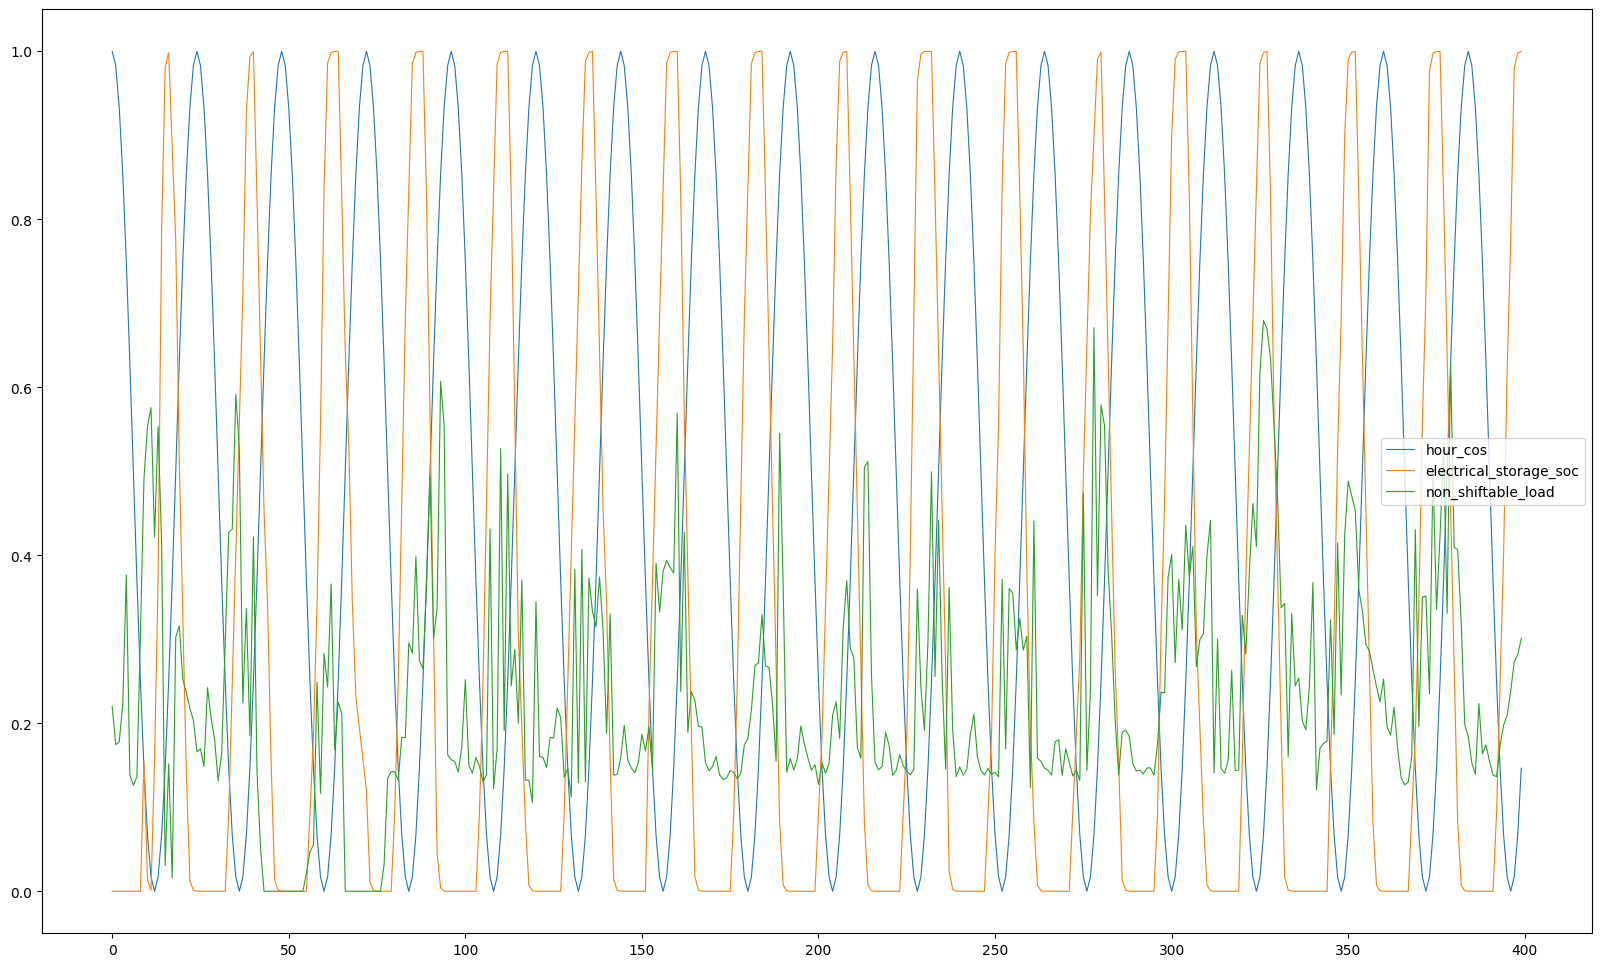

In [68]:
df_baseline_obs[[#'outdoor_dry_bulb_temperature',
                 'hour_cos',
                 'electrical_storage_soc',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]][:plot_len].plot.line(figsize=(20,12), lw=0.8)

<Axes: >

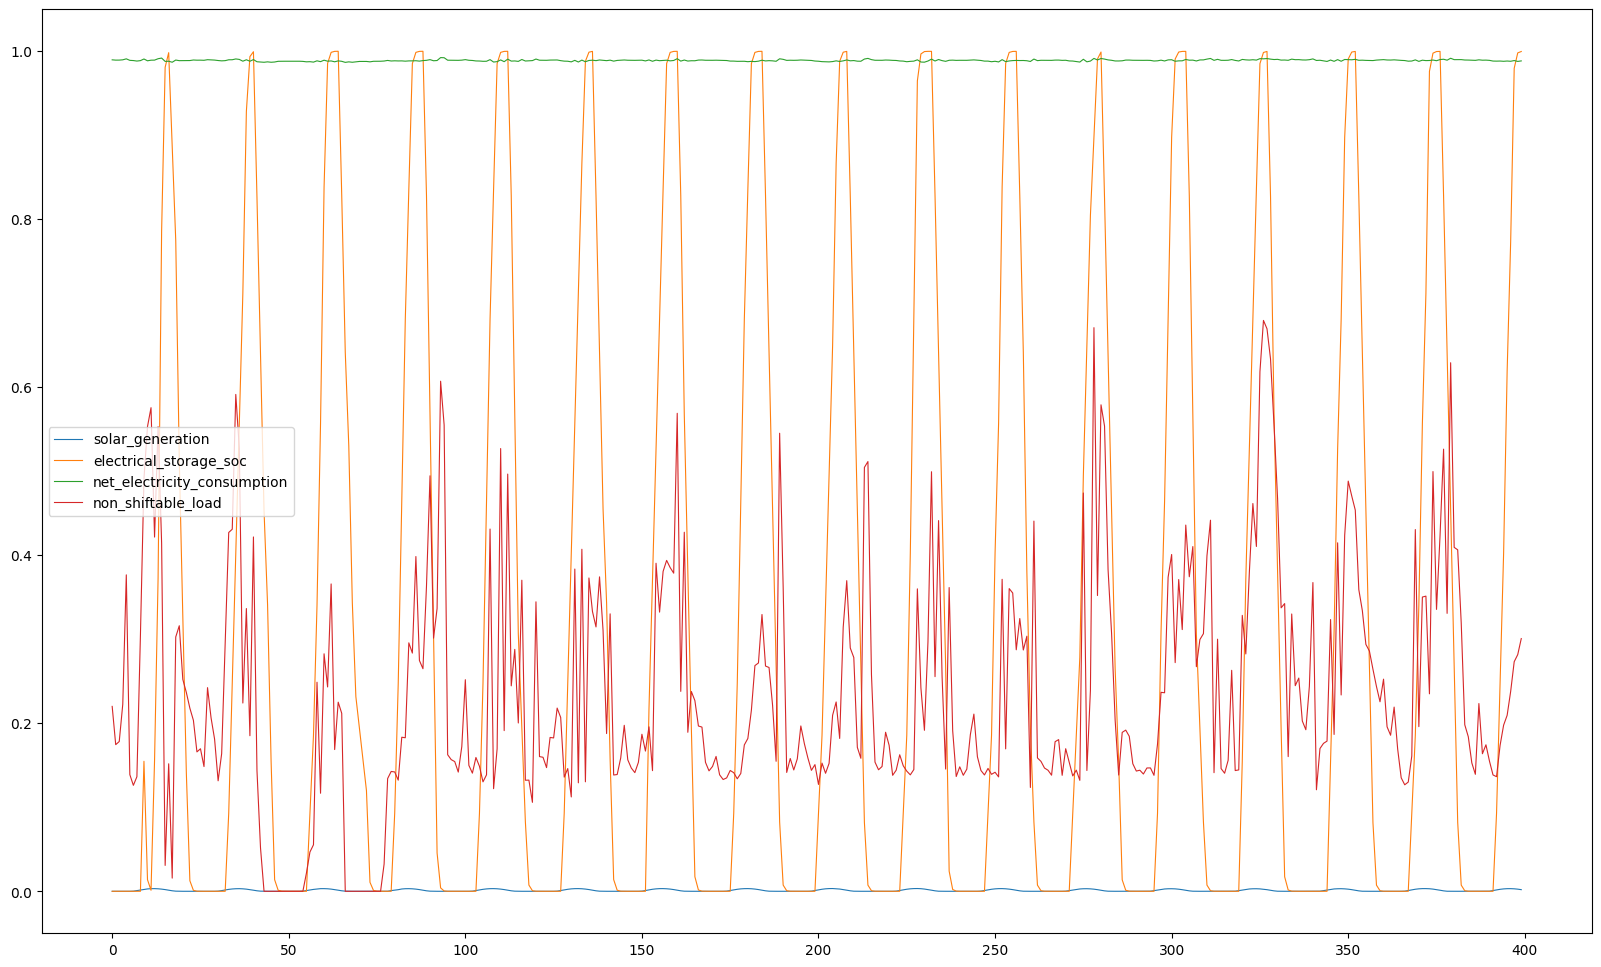

In [67]:
df_baseline_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]][:plot_len].plot.line(figsize=(20,12), lw=0.8)

Model performance while observations are perturbed by random noise [0,1). Note that all the observation values are normalized to [0,1]

epsilon of 5% has an asr of ~92% with ACG

In [16]:
rand_kpis, rand_obs, rand_a = utils.eval_rand_attack(agent, env, eps=0.05)


The Adversarial success rate is: 0.145662100456621


Here's the regret for the random attack:

In [17]:
display(baseline_kpis - rand_kpis)

cost_function
annual_peak_average                      3.330669e-16
carbon_emissions_total                  -2.573575e-03
cost_total                              -1.541838e-03
daily_one_minus_load_factor_average      1.238343e-01
daily_peak_average                      -4.220197e-05
electricity_consumption_total           -2.640841e-03
monthly_one_minus_load_factor_average   -5.856810e-03
ramping_average                         -2.644858e-03
zero_net_energy                          9.425161e-04
Name: District, dtype: float64

In [18]:
df_rand_obs = pd.DataFrame(rand_obs, columns=observation_names)

<Axes: >

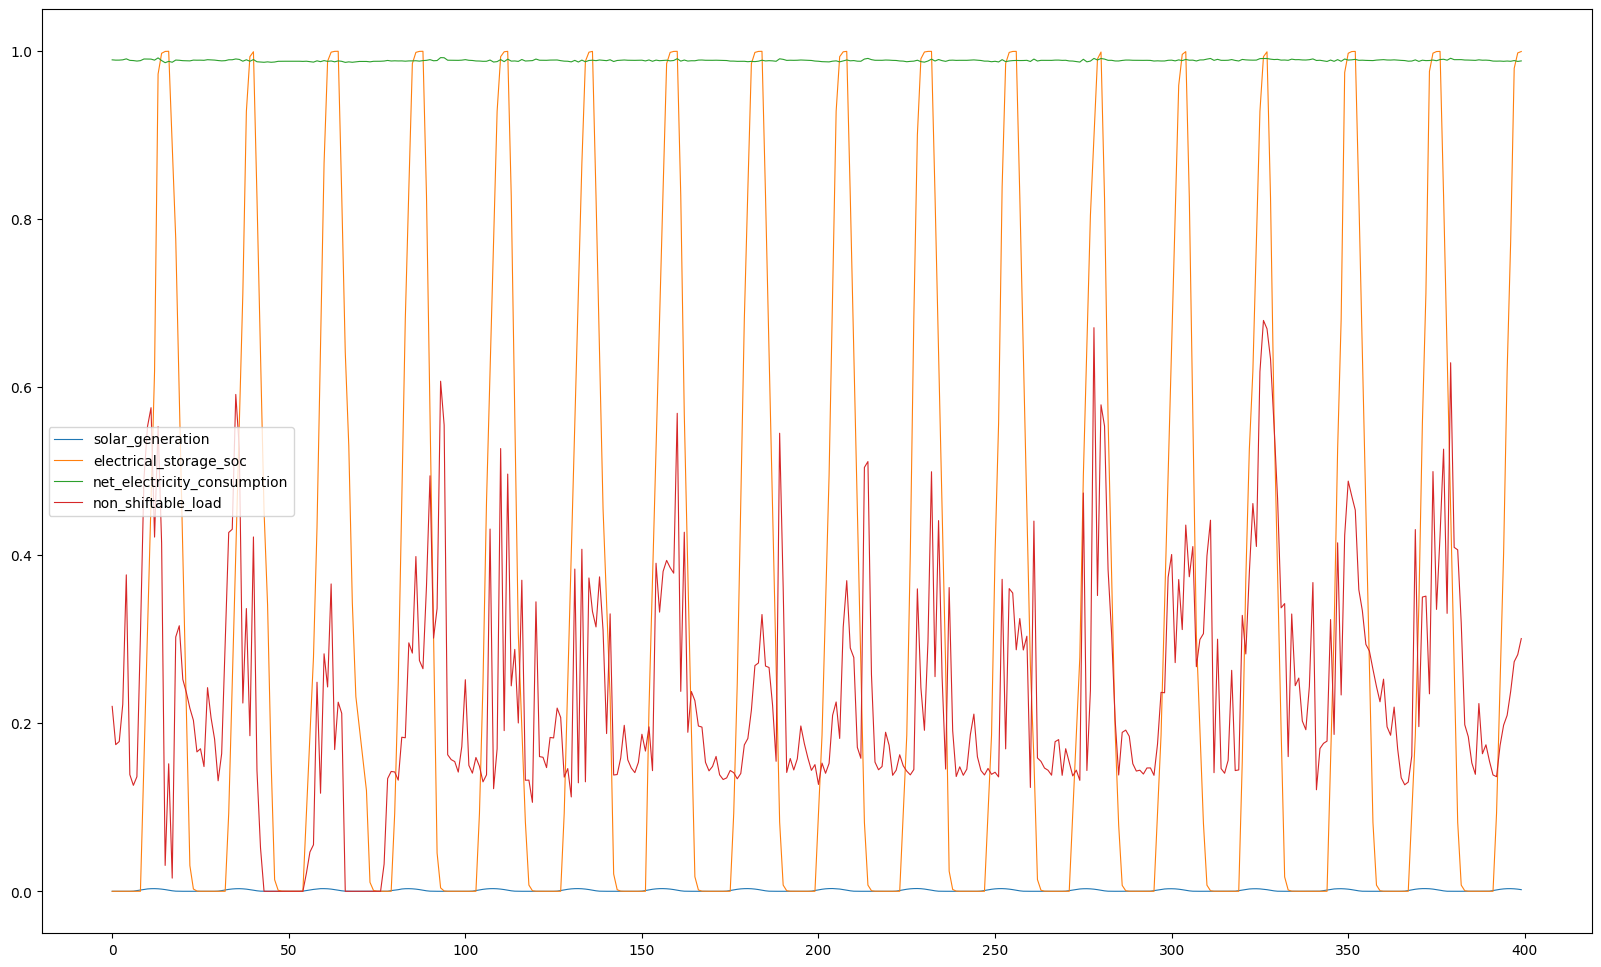

In [19]:
df_rand_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]][:plot_len].plot.line(figsize=(20,12), lw=0.8)

<Axes: >

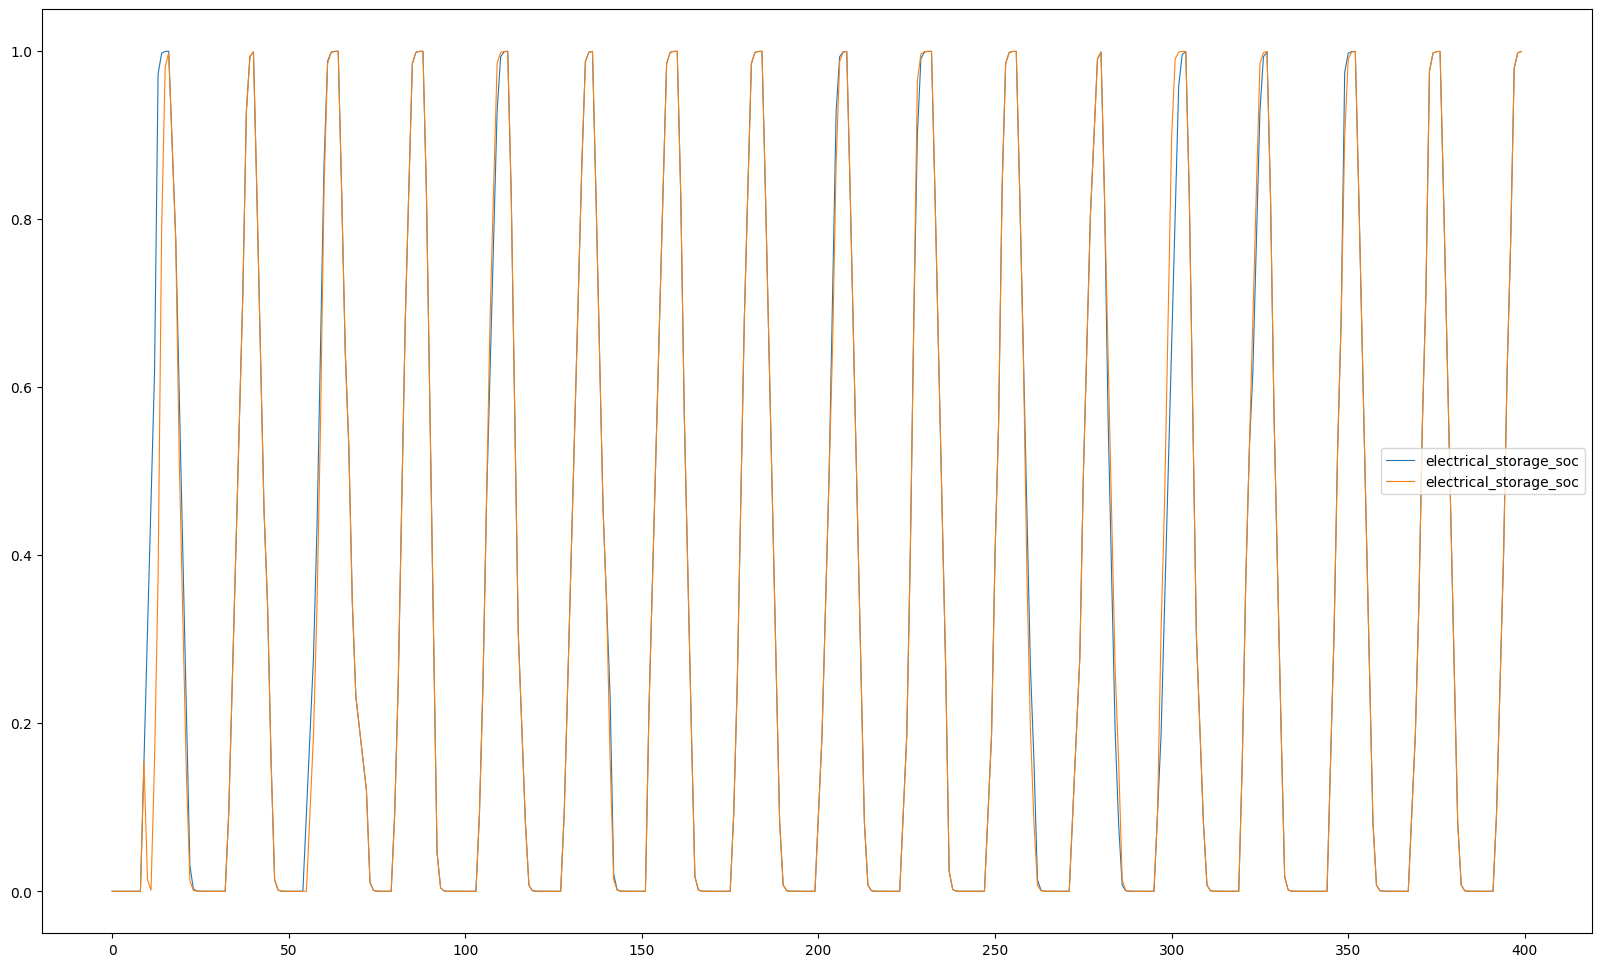

In [20]:
pd.concat([df_rand_obs['electrical_storage_soc'], df_baseline_obs['electrical_storage_soc']], axis=1)[:plot_len].plot.line(figsize=(20,12), lw=0.8)

Define our gradient based attack:

Before attacking the victim, we must understand what we are perturbing. So we need to see which observations/features are active in the environment (NB that periodically normalized calendar features are not properly named by the environment, so we will do it ourselves ref: https://github.com/intelligent-environments-lab/CityLearn/issues/74 ):

In [21]:
observation_masks = pd.Series(1, index=env.observation_names[0]).to_frame(name='all')

It seems that all these observations are variable (changes to constant values would indicate perturbations), however perturbations to the date and time would be obvious to an analyst. We will mask these features in our attack so they will not be perturbed.

In [22]:
observation_masks['mask_time'] = observation_masks['all']
observation_masks['mask_time'][observation_masks.index.str.contains('month|day|hour')] = 0

In [23]:
observation_masks

,all,mask_time
month_cos,1,0
month_sin,1,0
day_type_cos,1,0
day_type_sin,1,0
hour_cos,1,0
hour_sin,1,0
outdoor_dry_bulb_temperature,1,1
outdoor_dry_bulb_temperature_predicted_6h,1,1
outdoor_dry_bulb_temperature_predicted_12h,1,1
outdoor_dry_bulb_temperature_predicted_24h,1,1


Plot for preliminary results:
- outdoor_dry_bulb_temperature
- solar_generation
- electrical_storage_soc
- net_electricity_consumption
- electricity_pricing
- calculate power from grid/aggregate load

The adversarial regret from the untargeted adversarial attack is:

We could mask other features where tampering would be obvious e.g. temperture predictions vary between observations, but pricing predictions are identical for many obvservations and vary predictably.

In [24]:
init = 50
iter = int(500/init)
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    nb_random_init=init, #5, lower values speed crafting
    max_iter=iter, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
eps_list = [0.01, 0.03, 0.05, 0.07]

In [25]:

Adv_untargered_kpis, adv_obs, adv_untargeted_eps = utils.eval_untargeted_dynamic_distortion_attack(agent,
                                                        env,
                                                        ART_atk=ACG,
                                                        ART_atk_kwargs=ACG_parameters,
                                                        eps_candidates=eps_list,
                                                        time_steps=None,
                                                        mask=observation_masks['mask_time'].to_numpy())
display(Adv_untargered_kpis)

  0%|          | 0/8759 [00:00<?, ?it/s]

100%|█████████▉| 8758/8759 [3:20:29<00:01,  1.37s/it]  


The Adversarial success rate is: 0.998515812307341
The average distance between optinmal and adversarial actions is: 3.4988012330174656


cost_function
annual_peak_average                      1.000000
carbon_emissions_total                   0.905182
cost_total                               0.827309
daily_one_minus_load_factor_average      1.075258
daily_peak_average                       0.962026
electricity_consumption_total            0.915463
monthly_one_minus_load_factor_average    0.986193
ramping_average                          1.275755
zero_net_energy                          1.101851
Name: District, dtype: float64

In [26]:
s_adv_untargeted_eps = pd.Series(adv_untargeted_eps)

In [27]:
s_adv_untargeted_eps.value_counts()

0.01    4399
0.03    3601
0.05     649
0.07      97
dtype: int64

In [28]:
s_adv_untargeted_eps.describe()

count    8746.000000
mean        0.021868
std         0.013510
min         0.010000
25%         0.010000
50%         0.010000
75%         0.030000
max         0.070000
dtype: float64

In [29]:
df_adv_obs = pd.DataFrame(adv_obs, columns=observation_names)

In [30]:
df_adv_obs.to_csv('24 bin PPO results/adv_obs.csv')

<Axes: >

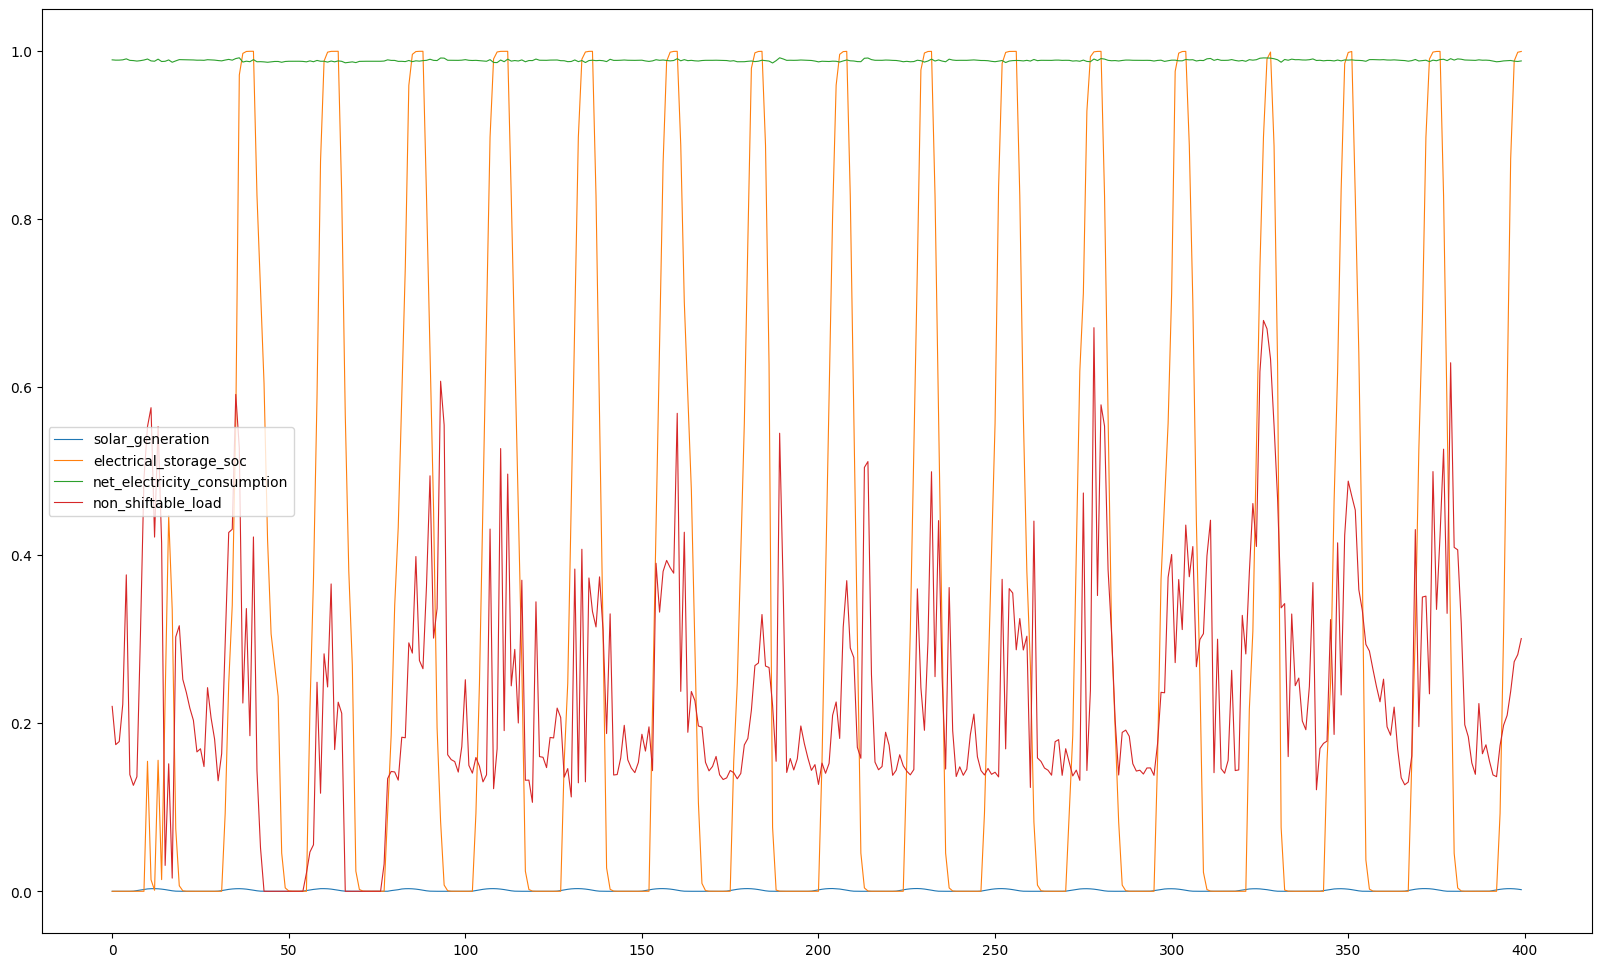

In [31]:
df_adv_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]][:plot_len].plot.line(figsize=(20,12), lw=0.8)

<Axes: >

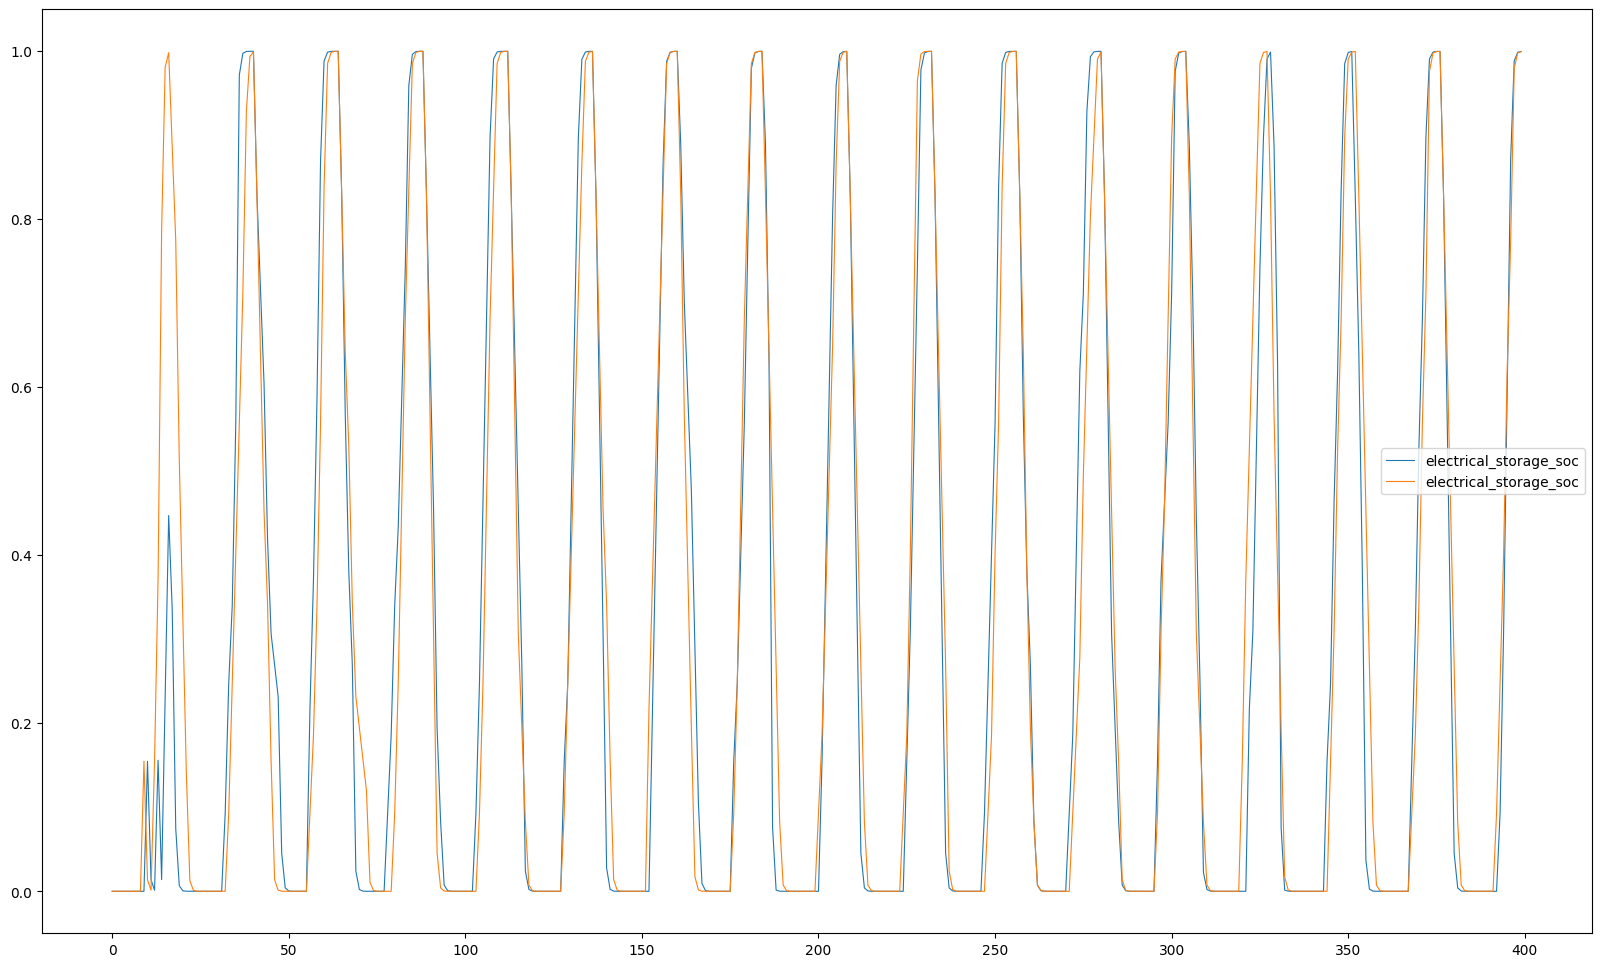

In [32]:
pd.concat([df_adv_obs['electrical_storage_soc'], df_baseline_obs['electrical_storage_soc']], axis=1)[:plot_len].plot.line(figsize=(20,12), lw=0.8)

Comparison of KPIs for all attacks

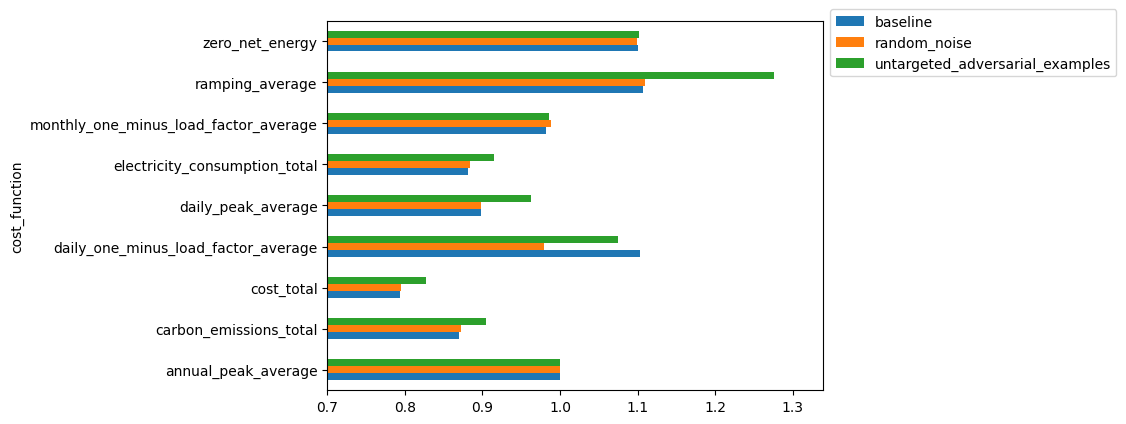

In [33]:
df_kpis = pd.concat([baseline_kpis, rand_kpis, Adv_untargered_kpis], axis=1)
df_kpis.columns = ['baseline','random_noise','untargeted_adversarial_examples']
df_kpis.plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

We can plot the KPIs where the adversarial examples worse performance.The victim agent was trained to minimize energy consumption, and below we see the untargeted adversarial attack has increased the power consumption whihle the effects of the random attack were negligable.

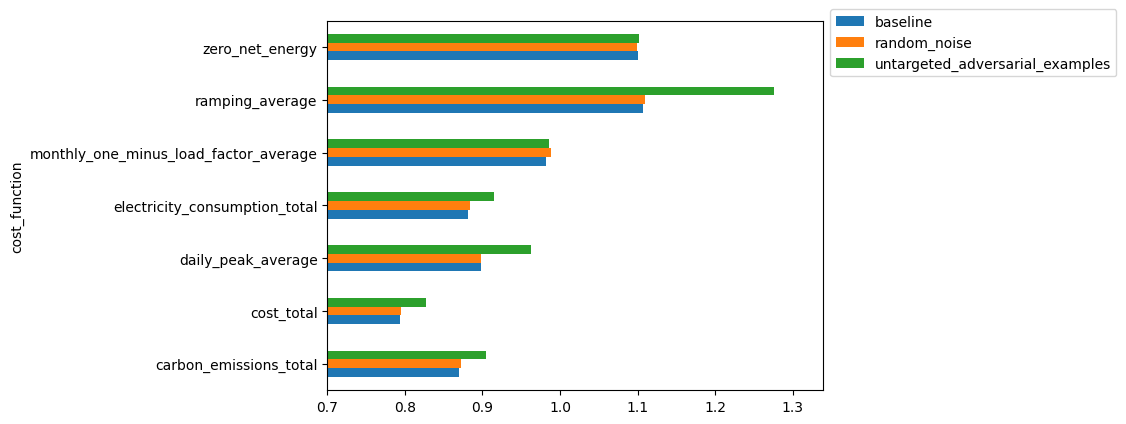

In [34]:
df_kpis[df_kpis['baseline'] < df_kpis['untargeted_adversarial_examples']].plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

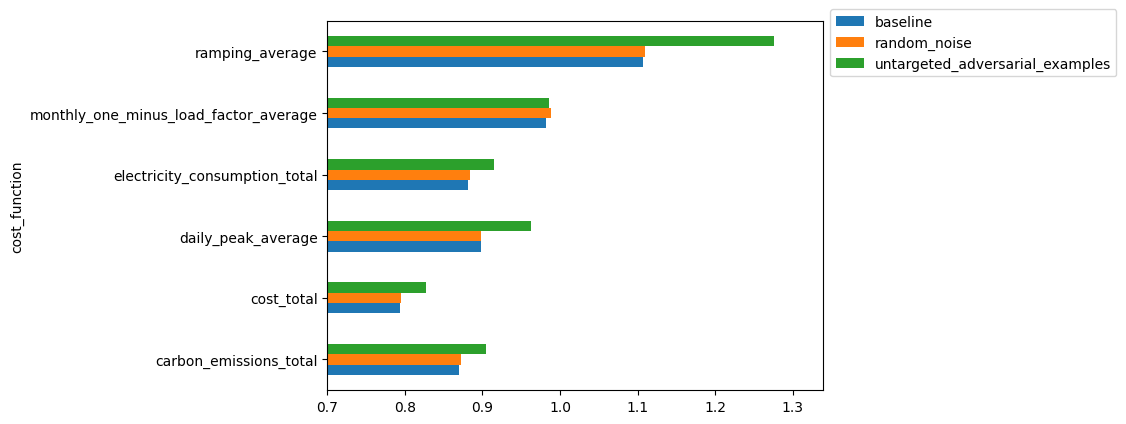

In [35]:
df_kpis[df_kpis['baseline'] < df_kpis['random_noise']].plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

In [36]:
df_kpis.to_csv('24 bin PPO results/KPIs.csv')

Value based adversarial attack:

This attack only adds perturbations when the value function is above the mean/median for a normal epidsode (98m):

In [37]:
%%time
Adv_v50_untargered_kpis, adv_v50_obs, adv_v50_eps = utils.eval_untargeted_dynamic_distortion_value_attack(agent,
                                                            env,
                                                            ART_atk=ACG,
                                                            ART_atk_kwargs=ACG_parameters,
                                                            eps_candidates=eps_list,
                                                            time_steps=None,
                                                            mask=observation_masks['mask_time'].to_numpy())
display(Adv_v50_untargered_kpis)

  0%|          | 0/8759 [00:00<?, ?it/s]

100%|█████████▉| 8758/8759 [1:44:10<00:00,  1.40it/s]  


The Adversarial success rate is: 0.9977298524404086
The perturbation rate was: 0.5029112912432926


cost_function
annual_peak_average                      1.000000
carbon_emissions_total                   0.890118
cost_total                               0.811151
daily_one_minus_load_factor_average      1.234915
daily_peak_average                       0.932684
electricity_consumption_total            0.902302
monthly_one_minus_load_factor_average    0.976168
ramping_average                          1.186773
zero_net_energy                          1.100747
Name: District, dtype: float64

CPU times: total: 1h 44min 8s
Wall time: 1h 44min 11s


In [38]:
pd.Series(adv_v50_eps).value_counts()

0.01    2135
0.03    1821
0.05     378
0.07      61
dtype: int64

This attack results in nearly idendical electircity consumption and a slightly smaller cost. Both are higher than the normal cases

<Axes: >

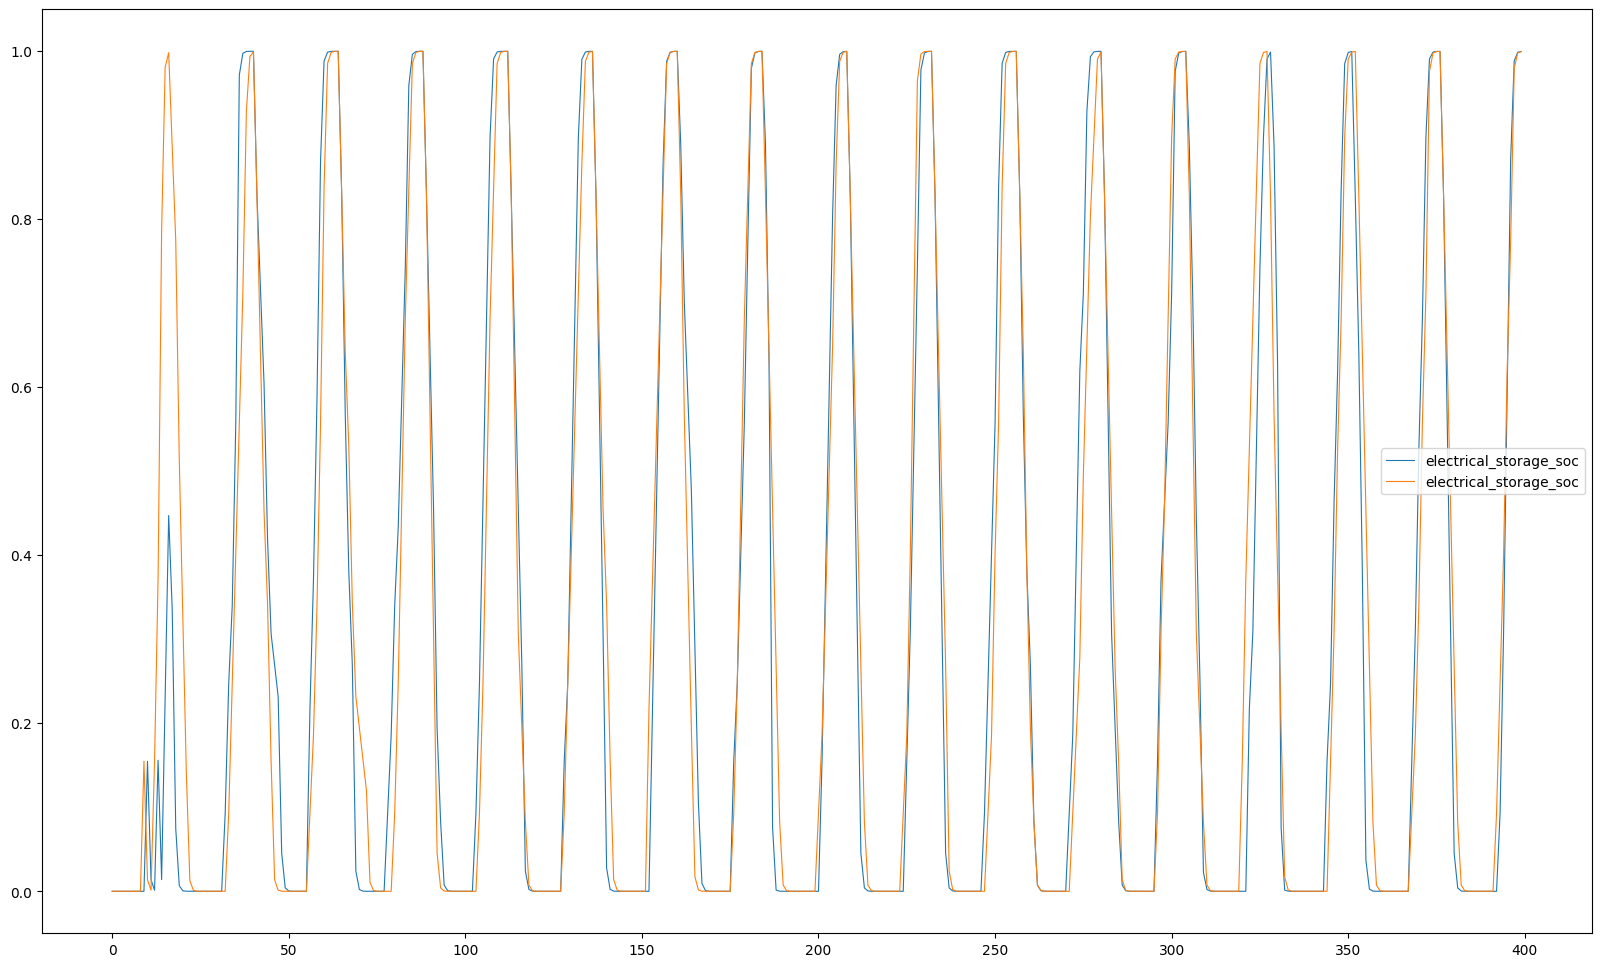

In [39]:
df_adv_v50_obs = pd.DataFrame(adv_obs, columns=observation_names)
pd.concat([df_adv_v50_obs['electrical_storage_soc'], df_baseline_obs['electrical_storage_soc']], axis=1)[:plot_len].plot.line(figsize=(20,12), lw=0.8)

<Axes: >

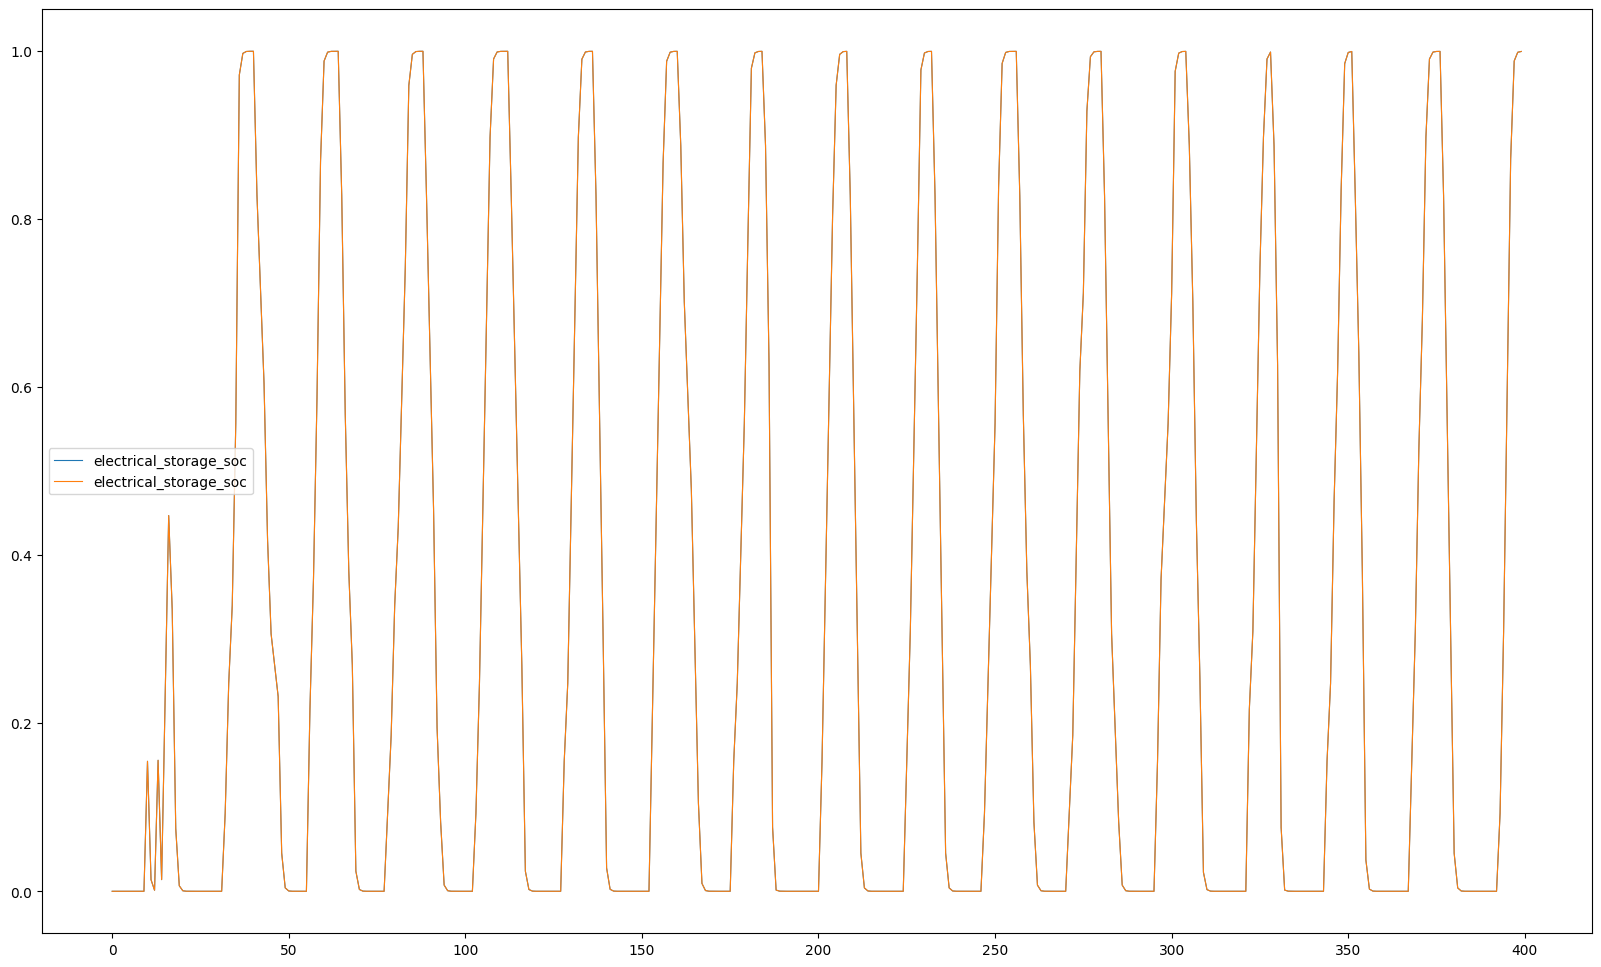

In [40]:
df_adv_v50_obs = pd.DataFrame(adv_obs, columns=observation_names)
pd.concat([df_adv_v50_obs['electrical_storage_soc'], df_adv_obs['electrical_storage_soc']], axis=1)[:plot_len].plot.line(figsize=(20,12), lw=0.8)

In [41]:
df_adv_v50_obs.to_csv('24 bin PPO results/adv_v50_obs.csv')

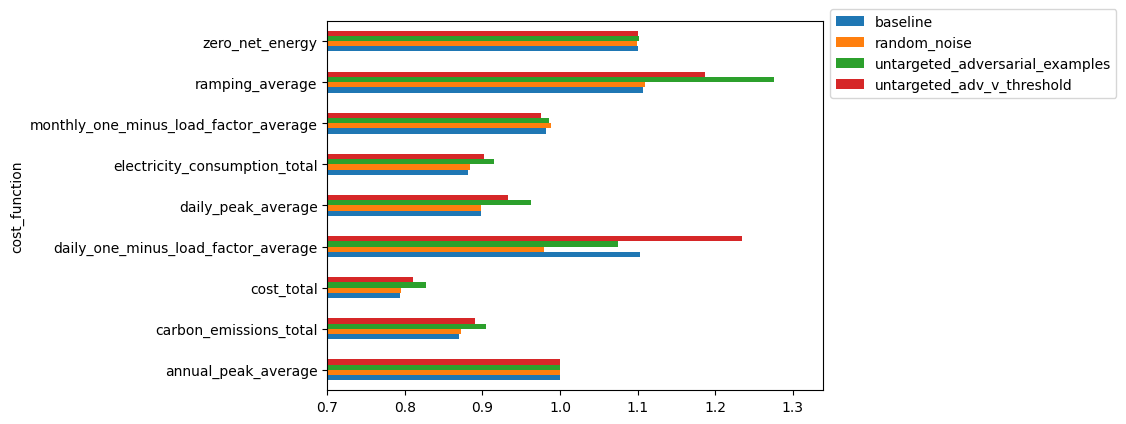

In [42]:
df_kpis = pd.concat([baseline_kpis, rand_kpis, Adv_untargered_kpis, Adv_v50_untargered_kpis], axis=1)
df_kpis.columns = ['baseline','random_noise','untargeted_adversarial_examples','untargeted_adv_v_threshold']
df_kpis.plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

for the first 400 ts we see little difference between the actions take with or without a value threshold

<Axes: >

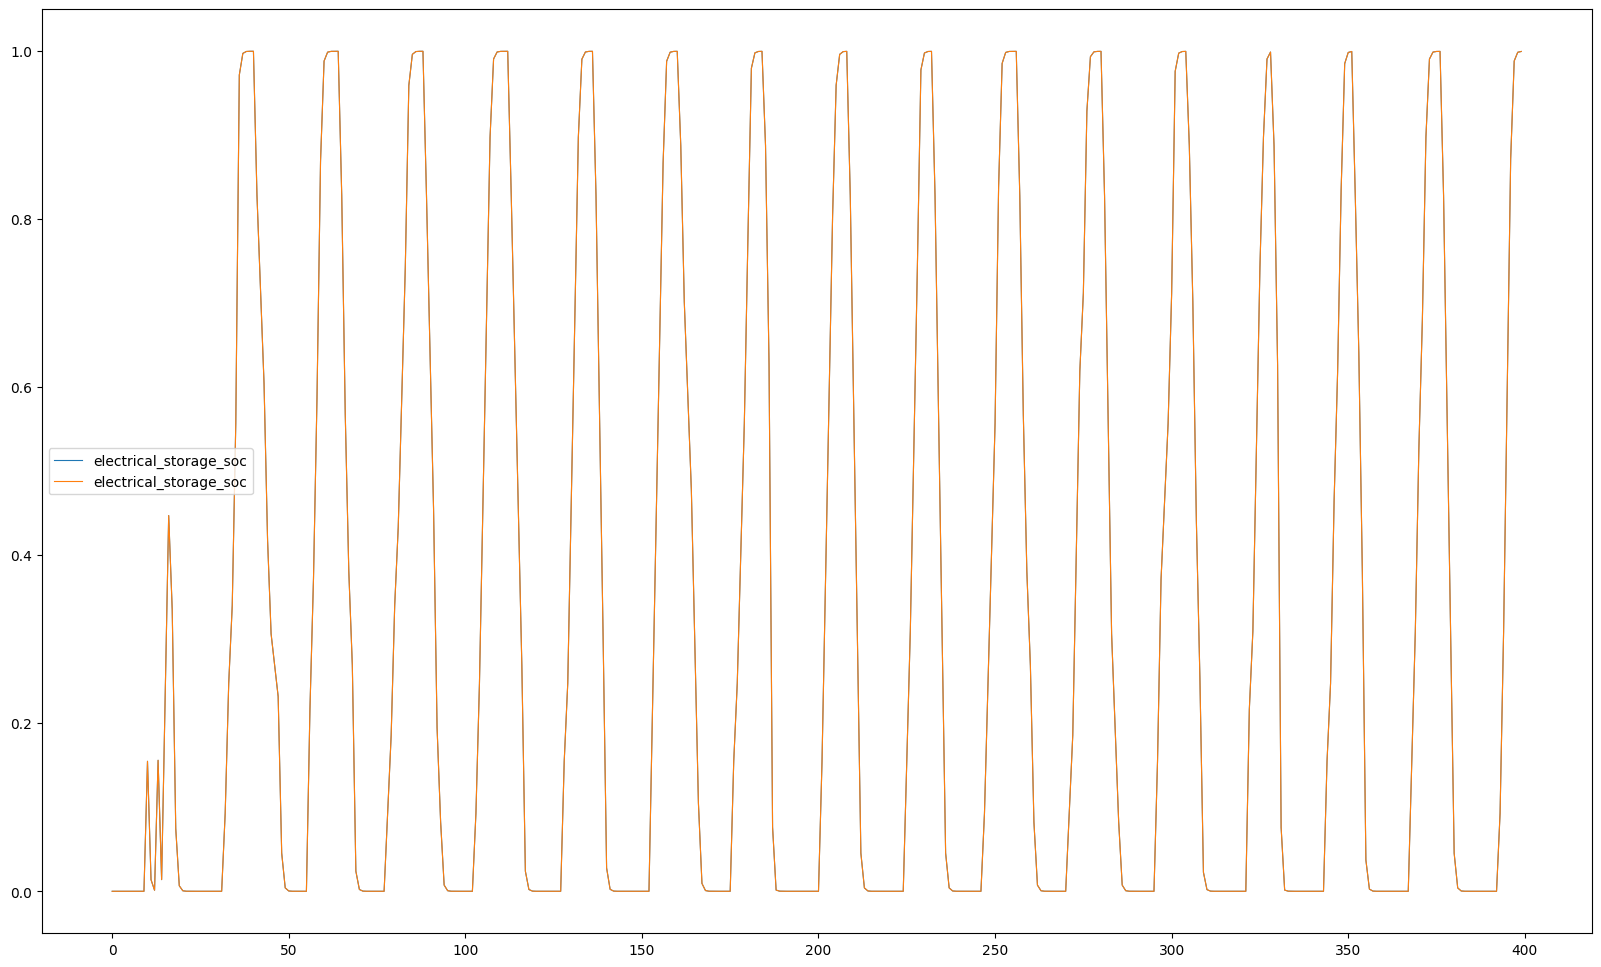

In [43]:
pd.concat([df_adv_obs['electrical_storage_soc'], df_adv_v50_obs['electrical_storage_soc']], axis=1)[:plot_len].plot.line(figsize=(20,12), lw=0.8)

We'll repeat the experiment for the 25% threshold (158m):

In [44]:
%%time
v25_percent = -93.6
Adv_v25_untargered_kpis, adv_v25_obs, adv_v25_eps = utils.eval_untargeted_dynamic_distortion_value_attack(agent,
                                                            env,
                                                            ART_atk=ACG,
                                                            ART_atk_kwargs=ACG_parameters,
                                                            eps_candidates=eps_list,
                                                            time_steps=None,
                                                            mask=observation_masks['mask_time'].to_numpy(),
                                                            value_threshold=v25_percent)
display(Adv_v25_untargered_kpis)

  0%|          | 0/8759 [00:00<?, ?it/s]

100%|█████████▉| 8758/8759 [2:32:30<00:01,  1.04s/it]  


The Adversarial success rate is: 0.9975587427525175
The perturbation rate was: 0.7482589336682269


cost_function
annual_peak_average                      1.000000
carbon_emissions_total                   0.898694
cost_total                               0.821485
daily_one_minus_load_factor_average      1.102612
daily_peak_average                       0.938119
electricity_consumption_total            0.910017
monthly_one_minus_load_factor_average    0.980435
ramping_average                          1.230991
zero_net_energy                          1.100853
Name: District, dtype: float64

CPU times: total: 2h 32min 26s
Wall time: 2h 32min 31s


In [45]:
pd.Series(adv_v25_eps).value_counts()

0.01    3235
0.03    2707
0.05     521
0.07      75
dtype: int64

In [46]:
df_adv_v25_obs = pd.DataFrame(adv_v25_obs, columns=env.observation_names[0])

In [47]:
df_adv_v25_obs.to_csv('24 bin PPO results/adv_v75_obs.csv')

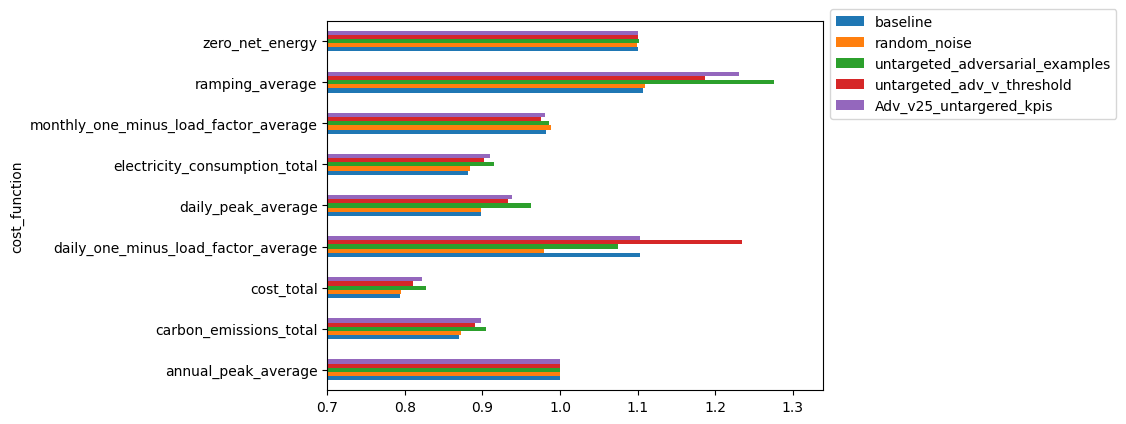

In [48]:
df_kpis = pd.concat([baseline_kpis, rand_kpis, Adv_untargered_kpis, Adv_v50_untargered_kpis, Adv_v25_untargered_kpis], axis=1)
df_kpis.columns = ['baseline','random_noise','untargeted_adversarial_examples','untargeted_adv_v_threshold', 'Adv_v25_untargered_kpis']
df_kpis.plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

In [49]:
df_kpis.to_csv('24 bin PPO results/KPIs.csv')

Now we'll try a smaller threshold for 25% of the step in a normal episode (53m):

In [50]:
%%time
v75_percent = -24.0
Adv_v75_untargered_kpis, adv_v75_obs, adv_v75_eps = utils.eval_untargeted_dynamic_distortion_value_attack(agent,
                                                            env,
                                                            ART_atk=ACG,
                                                            ART_atk_kwargs=ACG_parameters,
                                                            eps_candidates=eps_list,
                                                            time_steps=None,
                                                            mask=observation_masks['mask_time'].to_numpy(),
                                                            value_threshold=v75_percent)
display(Adv_v75_untargered_kpis)

  0%|          | 0/8759 [00:00<?, ?it/s]

100%|█████████▉| 8758/8759 [54:22<00:00,  2.68it/s]  


The Adversarial success rate is: 0.9982463831652784
The perturbation rate was: 0.2604178559196255


cost_function
annual_peak_average                      1.000000
carbon_emissions_total                   0.879969
cost_total                               0.802488
daily_one_minus_load_factor_average      1.044650
daily_peak_average                       0.917701
electricity_consumption_total            0.891775
monthly_one_minus_load_factor_average    0.974824
ramping_average                          1.152556
zero_net_energy                          1.100054
Name: District, dtype: float64

CPU times: total: 54min 21s
Wall time: 54min 23s


In [51]:
pd.Series(adv_v75_eps).value_counts()

0.01    1108
0.03     916
0.05     222
0.07      31
dtype: int64

In [52]:
df_adv_v75_obs = pd.DataFrame(adv_v75_obs, columns=env.observation_names[0])
df_adv_v75_obs.to_csv('24 bin PPO results/adv_v75_obs.csv')

In [53]:
df_adv_v75_obs.to_csv('24 bin PPO results/adv_v75_obs.csv')

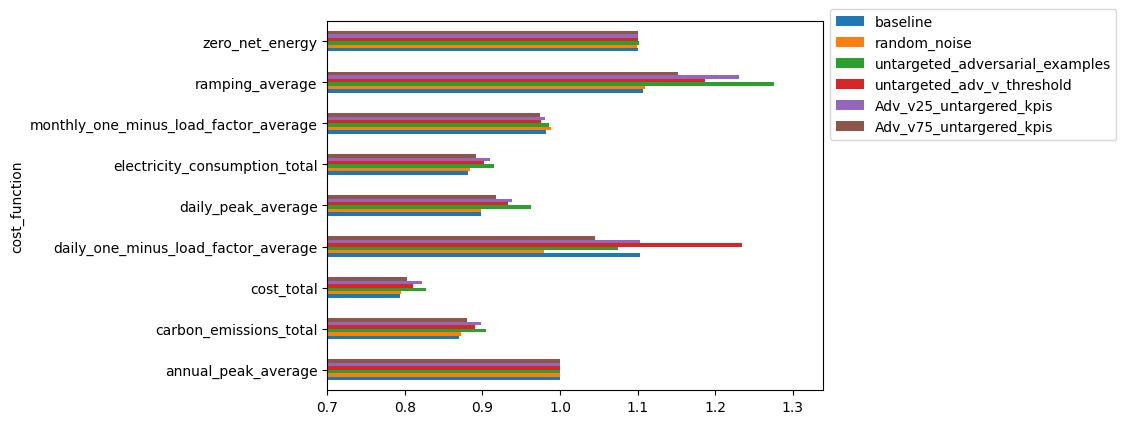

In [54]:
df_kpis = pd.concat([baseline_kpis, rand_kpis, Adv_untargered_kpis, Adv_v50_untargered_kpis, Adv_v25_untargered_kpis,Adv_v75_untargered_kpis ], axis=1)
df_kpis.columns = ['baseline','random_noise','untargeted_adversarial_examples','untargeted_adv_v_threshold', 'Adv_v25_untargered_kpis','Adv_v75_untargered_kpis']
df_kpis.plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

In [55]:
df_kpis.to_csv('24 bin PPO results/KPIs.csv')

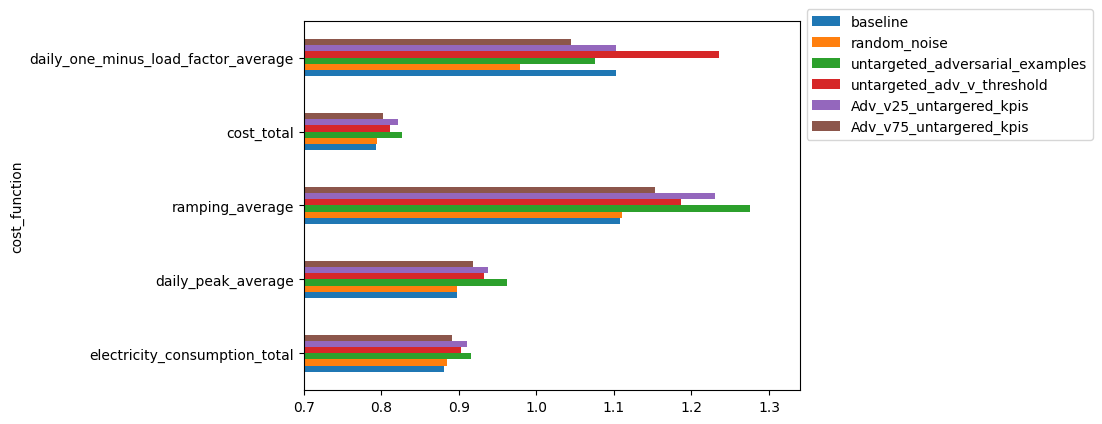

In [56]:
df_kpis.loc[['electricity_consumption_total','daily_peak_average','ramping_average','cost_total','daily_one_minus_load_factor_average']].plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

In [57]:
df_kpis

,baseline,random_noise,untargeted_adversarial_examples,untargeted_adv_v_threshold,Adv_v25_untargered_kpis,Adv_v75_untargered_kpis
cost_function,,,,,,
annual_peak_average,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
carbon_emissions_total,0.870297,0.872871,0.905182,0.890118,0.898694,0.879969
cost_total,0.793112,0.794653,0.827309,0.811151,0.821485,0.802488
daily_one_minus_load_factor_average,1.102841,0.979007,1.075258,1.234915,1.102612,1.044650
daily_peak_average,0.898169,0.898211,0.962026,0.932684,0.938119,0.917701
electricity_consumption_total,0.881560,0.884200,0.915463,0.902302,0.910017,0.891775
monthly_one_minus_load_factor_average,0.982159,0.988016,0.986193,0.976168,0.980435,0.974824
ramping_average,1.107352,1.109997,1.275755,1.186773,1.230991,1.152556
zero_net_energy,1.100263,1.099321,1.101851,1.100747,1.100853,1.100054


This test uses randomly selects observations to perturb with a 50% probability, as a comparison to the test with a mean value threshold:

In [58]:
%%time
df_v_ablation_kpis, v_ablation_obs, v_ablation_eps = utils.eval_untargeted_dynamic_distortion_rand_attack(agent, 
                                                            env,
                                                            ART_atk=ACG,
                                                            ART_atk_kwargs=ACG_parameters,
                                                            eps_candidates=eps_list,
                                                            time_steps=None,
                                                            mask=observation_masks['mask_time'].to_numpy(), 
                                                            rand_threshold=0.5)
display(df_v_ablation_kpis)

100%|█████████▉| 8758/8759 [1:40:55<00:00,  1.45it/s]  


The Adversarial success rate is: 0.9981994148098132
The perturbation rate was: 0.5072496860372189


cost_function
annual_peak_average                      1.000000
carbon_emissions_total                   0.887596
cost_total                               0.807673
daily_one_minus_load_factor_average      1.251741
daily_peak_average                       0.918994
electricity_consumption_total            0.898613
monthly_one_minus_load_factor_average    0.983147
ramping_average                          1.203106
zero_net_energy                          1.100778
Name: District, dtype: float64

CPU times: total: 1h 40min 52s
Wall time: 1h 40min 56s


In [59]:
pd.Series(v_ablation_eps).value_counts()

0.01    2259
0.03    1840
0.05     290
0.07      46
dtype: int64

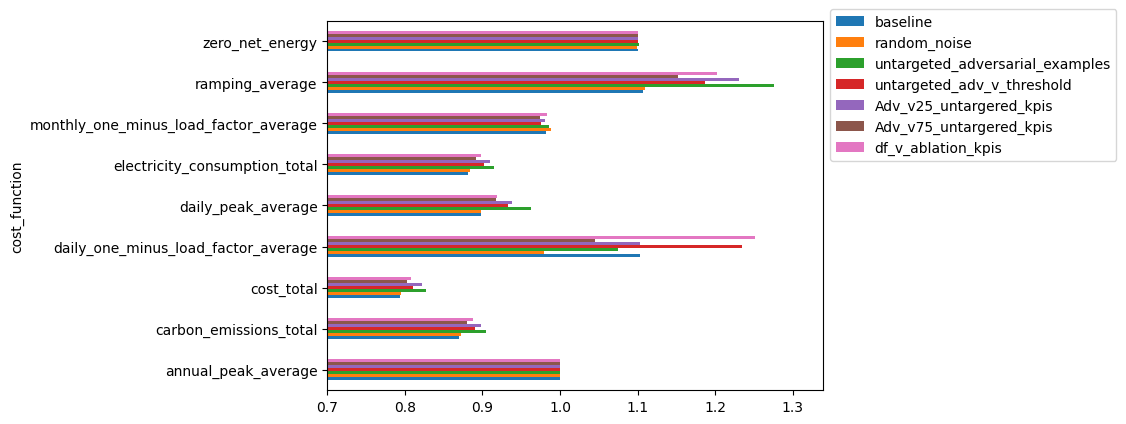

In [60]:
df_kpis = pd.concat([baseline_kpis, rand_kpis, Adv_untargered_kpis, Adv_v50_untargered_kpis, Adv_v25_untargered_kpis,Adv_v75_untargered_kpis, df_v_ablation_kpis], axis=1)
df_kpis.columns = ['baseline','random_noise','untargeted_adversarial_examples','untargeted_adv_v_threshold', 'Adv_v25_untargered_kpis','Adv_v75_untargered_kpis','df_v_ablation_kpis']
df_kpis.plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

In [61]:
df_kpis.to_csv('24 bin PPO results/KPIs.csv')

In [62]:
df_kpis

,baseline,random_noise,untargeted_adversarial_examples,untargeted_adv_v_threshold,Adv_v25_untargered_kpis,Adv_v75_untargered_kpis,df_v_ablation_kpis
cost_function,,,,,,,
annual_peak_average,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
carbon_emissions_total,0.870297,0.872871,0.905182,0.890118,0.898694,0.879969,0.887596
cost_total,0.793112,0.794653,0.827309,0.811151,0.821485,0.802488,0.807673
daily_one_minus_load_factor_average,1.102841,0.979007,1.075258,1.234915,1.102612,1.044650,1.251741
daily_peak_average,0.898169,0.898211,0.962026,0.932684,0.938119,0.917701,0.918994
electricity_consumption_total,0.881560,0.884200,0.915463,0.902302,0.910017,0.891775,0.898613
monthly_one_minus_load_factor_average,0.982159,0.988016,0.986193,0.976168,0.980435,0.974824,0.983147
ramping_average,1.107352,1.109997,1.275755,1.186773,1.230991,1.152556,1.203106
zero_net_energy,1.100263,1.099321,1.101851,1.100747,1.100853,1.100054,1.100778


From the graphs above and below, we see our random method is inferior to the value threshold with a similar perturbation rate.

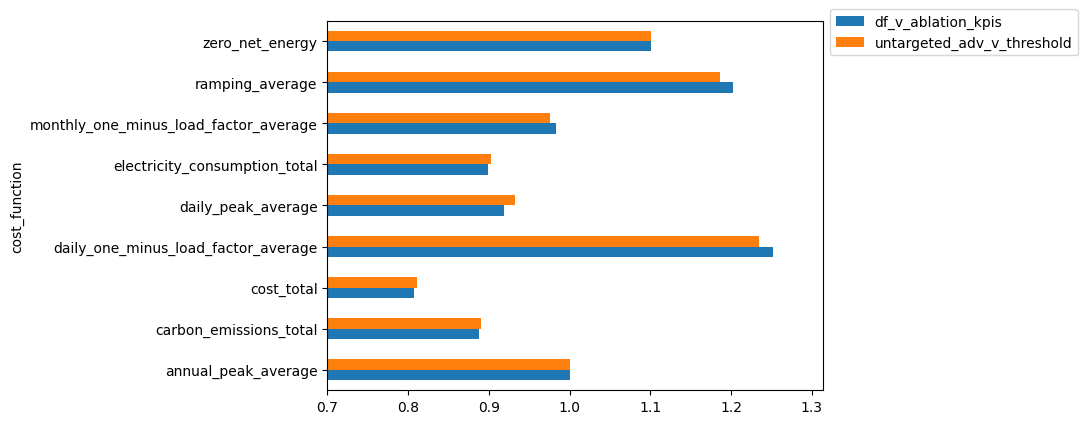

In [63]:
df_kpis[['df_v_ablation_kpis','untargeted_adv_v_threshold']].plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

In [64]:
df_eps = pd.Series(adv_untargeted_eps)
df_eps.to_csv('24 bin PPO results/Epsilons.csv')

Evaluate agent with variable epsilon:
- Start at min value and increase in loop
- try multiple values in parallel
- return stat on the eps used, box plot?